## Suffering niggas

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting
import catboost
import sklearn.preprocessing, sklearn.feature_selection, sklearn.model_selection
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

SEED = 42
np.random.seed = SEED

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [3]:
display(
    X_train.shape,
    X_train.columns,
    X_train.isnull().sum(),
)

(59400, 40)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [4]:
pd.Series({c: ([X_train[c].dtype] + list(X_train[c].unique()[:4])).__repr__() for c in X_train.columns})

amount_tsh                     [dtype('float64'), 6000.0, 0.0, 25.0, 20.0]
basin                    [dtype('O'), 'Lake Nyasa', 'Lake Victoria', 'P...
construction_year                 [dtype('int64'), 1999, 2010, 2009, 1986]
date_recorded            [dtype('O'), '2011-03-14', '2013-03-06', '2013...
district_code                                [dtype('int64'), 5, 2, 4, 63]
extraction_type          [dtype('O'), 'gravity', 'submersible', 'swn 80...
extraction_type_class    [dtype('O'), 'gravity', 'submersible', 'handpu...
extraction_type_group    [dtype('O'), 'gravity', 'submersible', 'swn 80...
funder                   [dtype('O'), 'Roman', 'Grumeti', 'Lottery Club...
gps_height                          [dtype('int64'), 1390, 1399, 686, 263]
id                             [dtype('int64'), 69572, 8776, 34310, 67743]
installer                [dtype('O'), 'Roman', 'GRUMETI', 'World vision...
latitude                 [dtype('float64'), -9.8563217699999992, -2.147...
lga                      

In [5]:
y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
import dateutil.parser

In [7]:
class HideMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            if np.issubdtype(X[c].dtype, np.number):
                X.loc[:,c].fillna(X.loc[:,c].median(), inplace=True)
            else:
                X.loc[:,c].fillna('Unknown', inplace=True)
                X.loc[:,c] = X[c].map(lambda x: str(x))
        return X
    
    
class DropGarbage(BaseEstimator, TransformerMixin):
    def __init__(self, cols=['id', 'funder', 'recorded_by', 'date_recorded']):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.cols, axis=1, errors='ignore')

class SplitDate(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def t(x):
            if isinstance(x, str):
                x = dateutil.parser.parse(x)
            return (x.year, x.month, x.day, x.weekday())
        X = X.copy()
        (X.loc[:, self.col + '_year'],
         X.loc[:, self.col + '_month'],
         X.loc[:, self.col + '_day'],
         X.loc[:, self.col + '_weekday']) = zip(
        *X.loc[:, self.col].map(t))
        return X

In [8]:
from sklearn.model_selection import train_test_split

In [ ]:
prepr1 = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('drop', DropGarbage(cols=['id', 'recorded_by', ]))
])

y_enc = sklearn.preprocessing.LabelEncoder()
X = prepr1.fit_transform(X_train)
y = y_enc.fit_transform(y_train.iloc[:,1])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.66)

!date
cbc1 = catboost.CatBoostClassifier(random_seed=SEED,
         loss_function='MultiClass',
         eval_set=(X_te, y_te))
cbc1.fit(X_tr,
         y_tr,
         cat_features=np.where(np.array([dt == object for dt in X.dtypes]))[0],
         verbose=False)
!date

In [ ]:
cbc1.score(X_te, y_te)

In [ ]:
X_train.iloc[0,[1,2]].values

In [ ]:
!head SubmissionFormat.csv

In [ ]:
y_test1 = cbc1.predict(prepr1.transform(X_test))

In [ ]:
y_test1[:4]

In [ ]:
ans1 = pd.DataFrame({'status_group': y_enc.inverse_transform(y_test1.astype(int).ravel())},
                    index= X_test.iloc[:,0].values)
ans1.index.name = 'id'
ans1.to_csv('ans1.csv')

In [ ]:
!head ans1.csv

In [9]:
import collections

In [10]:
class HandyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[:,'amount_per_man'] = X.loc[:,'amount_tsh']/X.loc[:,'population']
        return X

class OutcomeFrequences(BaseException, TransformerMixin):
    def __init__(self, groupby, drop=False):
        self.groupby = groupby
        self.drop = drop
        self.cnts_ = None
        self.fq_cols_ = None
        self.unknowns_ = 0
        
    def fit(self, X, y=None):
        possible_outcomes = [_.split()[-1] if isinstance(_, str) else _ for _ in np.unique(y)]
        n_outs = len(possible_outcomes)
        self.cnts_ = collections.defaultdict(lambda: np.zeros(n_outs))
        # print(self.groupby)
        igroupby = np.array([X.columns.get_loc(_) for _ in self.groupby])
        for i in range(X.shape[0]):
            # assuming $y$ is label-encoded
            keys, out = tuple(X.iloc[i, igroupby].values), y[i]
            self.cnts_[keys][out] += 1 # no of `(keys, out)` occurences
        for k in self.cnts_:
            self.cnts_[k] //= self.cnts_[k].sum()
            
        self.possible_outcomes_ = possible_outcomes
        self.fq_cols_ = ['_'.join(self.groupby + [str(out), 'fq'],) for out in possible_outcomes]
        return self
    
    def transform(self, X):
        self.unknowns_ = 0
        igroupby = np.array([X.columns.get_loc(_) for _ in self.groupby])
        new_cols = [tuple([None for out in self.possible_outcomes_]) for _ in range(X.shape[0])]
        for i in range(X.shape[0]):
            keys = tuple(X.iloc[i, igroupby].values)
            if keys in self.cnts_:
                new_cols[i] = tuple([self.cnts_[keys][out] for out in self.possible_outcomes_])
            else:
                self.unknowns_ += 1
        self.unknowns_ /= X.size
        # print(str(X)[:100])
        # print(str(new_cols)[:100])
        # print(str(self.fq_cols_[:100]))
        new_cols = pd.DataFrame(new_cols, columns=self.fq_cols_)
        for c in self.fq_cols_:
            new_cols.loc[:,c].fillna(0, inplace=True) # new_cols.loc[:,c].median(), inplace=True)
        X = pd.concat((X, new_cols,), axis=1)
        if self.drop:
            X.drop(self.groupby, axis=1, inplace=True, errors='ignore')
        return X


In [ ]:
prepr2 = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('handyfeats', HandyFeatures()),
    ('fq', OutcomeFrequences(['subvillage'])),
    ('drop', DropGarbage(cols=['id', 'recorded_by']))
])

y_enc = sklearn.preprocessing.LabelEncoder()
y = y_enc.fit_transform(y_train.iloc[:,1])
X = prepr2.fit_transform(X_train, y)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.66)


In [ ]:

!date
cbc2 = catboost.CatBoostClassifier(random_seed=SEED,
         loss_function='MultiClass',
         eval_set=(X_te, y_te))
cbc2.fit(X_tr,
         y_tr,
         cat_features=np.where(np.array([dt == object for dt in X.dtypes]))[0],
         verbose=False)
!date
display('score: %s' % cbc2.score(X_te, y_te))

In [ ]:

y_test2 = cbc2.predict(prepr2.transform(X_test))
ans2 = pd.DataFrame({'status_group': y_enc.inverse_transform(y_test2.astype(int).ravel())},
                    index= X_test.iloc[:,0].values)
ans2.index.name = 'id'
ans2.to_csv('ans2.csv')

In [11]:
import sklearn.utils
import itertools

Whoa! I overfited again! Drivendata scored it $0.8102$.
We need some 1) diversification and 2) to validate model more carefully.
We'll split train set into three parts this time and ensure we've got equal proportions of all classes in all of the (new_train, cv, test) sets.

In [12]:
def split_train_cv_test(X, y, proportions=(.75, .25/2, .25/2)):
    # expecting $y$ to be numpy array
    outs = np.unique(y)
    proportions = np.array(proportions)
    classes = [np.where(y == i)[0] for i in outs]
    xparts = [[] for _ in proportions]
    yparts = [[] for _ in proportions]
    for cidx in classes:
        cidx = sklearn.utils.shuffle(cidx)
        cprops = cidx.size * proportions
        cprops = cprops.astype(int)
        cprops[-1] = cidx.size - cprops[:-1].sum()
        cx = X.iloc[cidx,:]
        cy = y[cidx]
        for xpart, ypart, sz in zip(xparts, yparts, cprops):
            xpart.append(cx.iloc[:sz,:])
            ypart.append(cy[:sz])
            cx, cy = cx.iloc[sz:,:], cy[sz:]
    xparts = [pd.concat(xpart) for xpart in xparts]
    yparts = [np.concatenate(ypart) for ypart in yparts]
    # parts = []
    # print(len(xparts), 'parts')
    # for xpart, ypart in zip(xparts, yparts):
    #     parts.append(xpart)
    #     parts.append(ypart)
    parts = xparts + yparts
    return parts

In [58]:
X_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [13]:
def show_intersections(A, B):
    cat_features = np.where(np.array([(X_train[c].dtype == object)
                                  or (c.endswith('code')) for c in X_train.columns.values]))[0]
    cat_feats_observed = []
    for c in cat_features:
        n_uni = len(set(A.iloc[:,c]).union(B.iloc[:,c]))
        n_int = len(set(A.iloc[:,c]).intersection(B.iloc[:,c]))
        n_te = len(set(A.iloc[:,c]))
        cat_feats_observed.append((A.columns[c], n_int/n_uni, n_int/n_te))
    cat_feats_observed = (
        pd.DataFrame(cat_feats_observed, columns=['var', 'intersection/union', 'intersection/B'])
        .sort_values('intersection/B')
    )
    return cat_feats_observed

In [14]:
show_intersections(X_train, X_test)

,var,intersection/union,intersection/B
3,wpt_name,0.055950,0.068342
5,subvillage,0.294315,0.326939
2,installer,0.343011,0.385368
1,funder,0.344699,0.388830
14,scheme_name,0.563960,0.599926
0,date_recorded,0.861789,0.893258
13,scheme_management,0.923077,0.923077
10,ward,0.930887,0.933556
16,extraction_type,0.944444,0.944444
7,region_code,0.962963,0.962963


In [15]:
class ExplicitAge(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[:, 'age'] = X.loc[:,'date_recorded_year'] - X.loc[:,'construction_year']
        return X

In [16]:
prepr3 = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('handyfeats', HandyFeatures()),
    ('age', ExplicitAge()),
] + [
    ('_'.join(catcol) + '_fq', OutcomeFrequences(catcol, drop=False))
    for catcol in [
        ['date_recorded_year', 'date_recorded_month',],
    ]
] + [
    (catcol + '_fq', OutcomeFrequences([catcol], drop=True))
    for catcol in ['management', 'ward', 'scheme_name', 'region_code', 'extraction_type',
                   'construction_year',
                   'date_recorded_year',
                   'date_recorded_month',]
] + [
    (catcol + '_fq', OutcomeFrequences([catcol], drop=False))
    for catcol in ['basin', 'lga',
                   'extraction_type_class', 'region',]
] + [
    ('drop', DropGarbage(cols=[
        'id', 'recorded_by', 'date_recorded'
        'wtp_name', 'installer', 'funder', 'subvillage', # the top of intersection table
        'longtitude', 'latitude',
        'date_recorded_day', 'date_recorded_weekday',
    ]))
])


In [17]:
y_enc = sklearn.preprocessing.LabelEncoder()
y = y_enc.fit_transform(y_train.iloc[:,1])

In [18]:
X = prepr3.fit_transform(X_train, y)

In [19]:
!date

Fri Jul 28 15:03:41 MSK 2017


In [20]:
X_tr, X_cv, X_te, y_tr, y_cv, y_te = split_train_cv_test(X, y)

/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


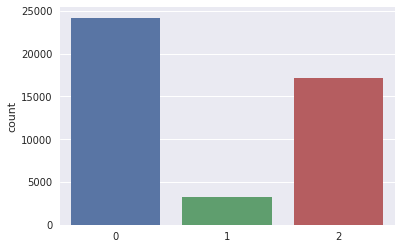

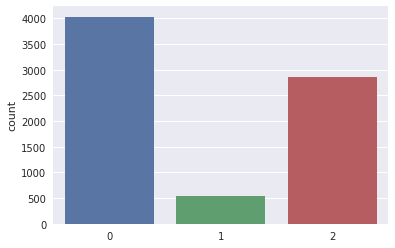

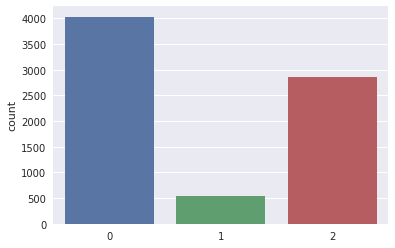

In [21]:
sns.countplot(y_tr)
plt.show()
sns.countplot(y_cv)
plt.show()
sns.countplot(y_te)

In [22]:
!date
cbc3 = catboost.CatBoostClassifier(random_seed=SEED,
         loss_function='MultiClass',
         eval_set=(X_cv, y_cv))
cbc3.fit(X_tr,
         y_tr,
         cat_features=np.where(np.array([(X[c].dtype == object)
                                  or (c.endswith('code')) for c in X.columns.values]))[0],
         verbose=True)
!date

display('cv score: %s' % cbc3.score(X_cv, y_cv))
display('test score: %s' % cbc3.score(X_te, y_te))

Fri Jul 28 15:03:44 MSK 2017
Borders generated
0:	learn -1.072085383passed: 0.532 sec	total: 972ms	remaining: 8m 5s
1:	learn -1.047807589passed: 0.481 sec	total: 1.45s	remaining: 6m 1s
2:	learn -1.024451385passed: 0.526 sec	total: 1.98s	remaining: 5m 27s
3:	learn -1.002501661passed: 0.53 sec	total: 2.51s	remaining: 5m 11s
4:	learn -0.9820205679passed: 0.452 sec	total: 2.96s	remaining: 4m 53s
5:	learn -0.9625875968passed: 0.451 sec	total: 3.41s	remaining: 4m 41s
6:	learn -0.9443652408passed: 0.506 sec	total: 3.92s	remaining: 4m 36s
7:	learn -0.9276026648passed: 0.441 sec	total: 4.36s	remaining: 4m 28s
8:	learn -0.9117098578passed: 0.549 sec	total: 4.91s	remaining: 4m 27s
9:	learn -0.896959246passed: 0.452 sec	total: 5.36s	remaining: 4m 22s
10:	learn -0.882738424passed: 0.461 sec	total: 5.82s	remaining: 4m 18s
11:	learn -0.8694885131passed: 0.541 sec	total: 6.36s	remaining: 4m 18s
12:	learn -0.8565667305passed: 0.439 sec	total: 6.8s	remaining: 4m 14s
13:	learn -0.8442810149passed: 0.468 

115:	learn -0.555056192passed: 0.514 sec	total: 57s	remaining: 3m 8s
116:	learn -0.554529975passed: 0.499 sec	total: 57.5s	remaining: 3m 8s
117:	learn -0.5539498436passed: 0.475 sec	total: 58s	remaining: 3m 7s
118:	learn -0.5535904562passed: 0.44 sec	total: 58.4s	remaining: 3m 7s
119:	learn -0.5531519137passed: 0.479 sec	total: 58.9s	remaining: 3m 6s
120:	learn -0.5526404138passed: 0.526 sec	total: 59.4s	remaining: 3m 6s
121:	learn -0.5521580708passed: 0.473 sec	total: 59.9s	remaining: 3m 5s
122:	learn -0.5517815264passed: 0.59 sec	total: 1m	remaining: 3m 5s
123:	learn -0.5513792474passed: 0.516 sec	total: 1m	remaining: 3m 4s
124:	learn -0.550856081passed: 0.504 sec	total: 1m 1s	remaining: 3m 4s
125:	learn -0.5506009615passed: 0.605 sec	total: 1m 2s	remaining: 3m 4s
126:	learn -0.5502307216passed: 0.473 sec	total: 1m 2s	remaining: 3m 3s
127:	learn -0.5499665963passed: 0.54 sec	total: 1m 3s	remaining: 3m 3s
128:	learn -0.5493493602passed: 0.522 sec	total: 1m 3s	remaining: 3m 3s
129:	lea

227:	learn -0.5240647047passed: 0.512 sec	total: 1m 51s	remaining: 2m 13s
228:	learn -0.5239673101passed: 0.457 sec	total: 1m 52s	remaining: 2m 12s
229:	learn -0.523805694passed: 0.509 sec	total: 1m 52s	remaining: 2m 12s
230:	learn -0.5236022527passed: 0.608 sec	total: 1m 53s	remaining: 2m 12s
231:	learn -0.5233688passed: 0.531 sec	total: 1m 53s	remaining: 2m 11s
232:	learn -0.5232797646passed: 0.271 sec	total: 1m 54s	remaining: 2m 10s
233:	learn -0.5231884799passed: 0.455 sec	total: 1m 54s	remaining: 2m 10s
234:	learn -0.5229860194passed: 0.533 sec	total: 1m 55s	remaining: 2m 9s
235:	learn -0.5228382566passed: 0.477 sec	total: 1m 55s	remaining: 2m 9s
236:	learn -0.5227614991passed: 0.217 sec	total: 1m 55s	remaining: 2m 8s
237:	learn -0.5225729237passed: 0.519 sec	total: 1m 56s	remaining: 2m 8s
238:	learn -0.522166557passed: 0.472 sec	total: 1m 56s	remaining: 2m 7s
239:	learn -0.5219018656passed: 0.524 sec	total: 1m 57s	remaining: 2m 7s
240:	learn -0.5216895994passed: 0.541 sec	total: 

339:	learn -0.5089593558passed: 0.564 sec	total: 2m 47s	remaining: 1m 18s
340:	learn -0.5088872516passed: 0.444 sec	total: 2m 48s	remaining: 1m 18s
341:	learn -0.5087166022passed: 0.449 sec	total: 2m 48s	remaining: 1m 17s
342:	learn -0.5086294505passed: 0.432 sec	total: 2m 49s	remaining: 1m 17s
343:	learn -0.5084557929passed: 0.496 sec	total: 2m 49s	remaining: 1m 16s
344:	learn -0.5083182136passed: 0.527 sec	total: 2m 50s	remaining: 1m 16s
345:	learn -0.508254805passed: 0.528 sec	total: 2m 50s	remaining: 1m 15s
346:	learn -0.5081502014passed: 0.575 sec	total: 2m 51s	remaining: 1m 15s
347:	learn -0.5080303722passed: 0.531 sec	total: 2m 51s	remaining: 1m 14s
348:	learn -0.5079469641passed: 0.548 sec	total: 2m 52s	remaining: 1m 14s
349:	learn -0.5078543336passed: 0.554 sec	total: 2m 52s	remaining: 1m 14s
350:	learn -0.5078100088passed: 0.542 sec	total: 2m 53s	remaining: 1m 13s
351:	learn -0.5077237353passed: 0.568 sec	total: 2m 53s	remaining: 1m 13s
352:	learn -0.5076592211passed: 0.589 s

452:	learn -0.4974442318passed: 0.524 sec	total: 3m 46s	remaining: 23.5s
453:	learn -0.4973551431passed: 0.522 sec	total: 3m 46s	remaining: 23s
454:	learn -0.4972398205passed: 0.532 sec	total: 3m 47s	remaining: 22.5s
455:	learn -0.4971765411passed: 0.595 sec	total: 3m 47s	remaining: 22s
456:	learn -0.4971193348passed: 0.527 sec	total: 3m 48s	remaining: 21.5s
457:	learn -0.4971015125passed: 0.592 sec	total: 3m 49s	remaining: 21s
458:	learn -0.4969928293passed: 0.46 sec	total: 3m 49s	remaining: 20.5s
459:	learn -0.4969510412passed: 0.561 sec	total: 3m 50s	remaining: 20s
460:	learn -0.4968591089passed: 0.579 sec	total: 3m 50s	remaining: 19.5s
461:	learn -0.4967081194passed: 0.5 sec	total: 3m 51s	remaining: 19s
462:	learn -0.4966697611passed: 0.546 sec	total: 3m 51s	remaining: 18.5s
463:	learn -0.4965858664passed: 0.512 sec	total: 3m 52s	remaining: 18s
464:	learn -0.4965087341passed: 0.517 sec	total: 3m 52s	remaining: 17.5s
465:	learn -0.4964144443passed: 0.515 sec	total: 3m 53s	remaining:

'cv score: 0.800646551724'

'test score: 0.804227817423'

In [23]:
y_test3 = cbc3.predict(prepr3.transform(X_test))
for sn, st in prepr3.steps:
    if sn.endswith('_fq'):
        display('%s: %s unknowns' % (sn, st.unknowns_))

'date_recorded_year_date_recorded_month_fq: 4.39174352218e-06 unknowns'

'management_fq: 0.0 unknowns'

'ward_fq: 1.32039347726e-05 unknowns'

'scheme_name_fq: 0.000237596086653 unknowns'

'region_code_fq: 0.0 unknowns'

'extraction_type_fq: 0.0 unknowns'

'construction_year_fq: 0.0 unknowns'

'date_recorded_year_fq: 1.10393553017e-06 unknowns'

'date_recorded_month_fq: 0.0 unknowns'

'basin_fq: 0.0 unknowns'

'lga_fq: 0.0 unknowns'

'extraction_type_class_fq: 0.0 unknowns'

'region_fq: 0.0 unknowns'

In [24]:
ans3 = pd.DataFrame({'status_group': y_enc.inverse_transform(y_test3.astype(int).ravel())},
                    index= X_test.iloc[:,0].values)
ans3.index.name = 'id'
ans3.to_csv('ans3.csv')

In [26]:
!head ans1.csv ans2.csv ans3.csv

==> ans1.csv <==
id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional

==> ans2.csv <==
id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional

==> ans3.csv <==
id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,non functional


In [25]:
display('score on a full train: %s' % cbc3.score(X, y))

'score on a full train: 0.833265993266'

In [ ]:
prepr4 = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('handyfeats', HandyFeatures()),
    ('district_fq', OutcomeFrequences(['district_code'])),
    ('extraction_t_c_fq', OutcomeFrequences(['extraction_type_class'])),
    ('age', ExplicitAge()),
    ('drop', DropGarbage(cols=[
        'id', 'recorded_by',
        'region', 'funder', 'installer',
        'wtp_name', 'scheme_management',
        'num_private', 'subvillage', 
        'longtitude', 'latitude',
        'date_recorded_day', 'date_recorded_weekday'
    ]))
])

y = y_enc.fit_transform(y_train.iloc[:,1])
X = prepr4.fit_transform(X_train, y)
X_tr, X_cv, X_te, y_tr, y_cv, y_te = split_train_cv_test(X, y)
!date
cbc4 = catboost.CatBoostClassifier(random_seed=SEED,
         loss_function='MultiClass',
         eval_set=(X_cv, y_cv))
cbc4.fit(X_tr,
         y_tr,
         cat_features=cat_features,
         verbose=True)
!date
display('score: %s' % cbc4.score(X_te, y_te))
y_test4 = cbc4.predict(prepr4.transform(X_test))
ans4 = pd.DataFrame({'status_group': y_enc.inverse_transform(y_test4.astype(int).ravel())},
                    index= X_test.iloc[:,0].values)
ans4.index.name = 'id'
ans4.to_csv('ans4.csv')

In [ ]:
prepr5 = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('drop', DropGarbage(cols=['id', 'recorded_by', 'wpt_name']))
])

y_enc = sklearn.preprocessing.LabelEncoder()
X = prepr5.fit_transform(X_train)
y = y_enc.fit_transform(y_train.iloc[:,1])

X_tr, X_cv, X_te, y_tr, y_cv, y_te = split_train_cv_test(X, y)

!date
cbc5 = catboost.CatBoostClassifier(random_seed=SEED,
         loss_function='MultiClass',
         eval_set=(X_te, y_te),
         auto_stop_pval=1e-10)
cbc5.fit(X_tr,
         y_tr,
         cat_features=np.where(np.array([dt == object for dt in X.dtypes]))[0],
         verbose=False)
display('cv score: %s' % cbc5.score(X_cv, y_cv))
display('test score: %s' % cbc5.score(X_te, y_te))

y_test5 = cbc5.predict(prepr5.transform(X_test))
ans5 = pd.DataFrame({'status_group': y_enc.inverse_transform(y_test5.astype(int).ravel())},
                    index= X_test.iloc[:,0].values)
ans5.index.name = 'id'
ans5.to_csv('ans5.csv')
!date